### **Credit Card Fraud Detection Using Machine Learning**

Credit card fraud is a significant issue in financial security, and machine learning models can help detect fraudulent transactions. This project aims to build and evaluate multiple models to classify fraudulent and non-fraudulent transactions using a dataset from Kaggle.




#### Dataset Overview
- **Total Entries**: 100,000 transactions
- **Columns**:
  - `TransactionID` (int): Unique identifier for each transaction
  - `TransactionDate` (object): Timestamp of the transaction
  - `Amount` (float): Transaction amount
  - `MerchantID` (int): ID of the merchant
  - `TransactionType` (object): Type of transaction (e.g., purchase, refund)
  - `Location` (object): Location where the transaction occurred
  - `IsFraud` (int): **Target variable** (0 = legitimate, 1 = fraud)

let's proceed! 🚀

 #### Project Workflow

 1. Data Preprocessing
 2. Exploratory Data Analysis (EDA)
 3. Handling Class Imbalance and Feature Scaling
 4. Model Training & Evaluation 
 5. Hyperparameter Tuning
 6. Conclusion & Future Improvements
 7. 

#### 1. Data Loading and Preprocessing

1.1 Import Required Libraries




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
import gc


# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Set the style for matplotlib plots
sns.set_palette("viridis")

warnings.filterwarnings('ignore')

gc.enable()  # Enable garbage collection

1.2 Load Dataset

In [4]:
# Load the dataset
df = pd.read_csv('credit_card_fraud_dataset.csv')
print("Dataset loaded successfully!")
print("Shape of dataset:", df.shape)



Dataset loaded successfully!
Shape of dataset: (100000, 7)


1.3 Check for Missing Values

In [5]:
print(df.isnull().sum().sum())  # No missing values expected

# Display basic info and first few rows
df_info = df.info()
df_head = df.head()




0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


1.4 Data Cleaning and Feature Engineering

In [6]:
# Convert 'TransactionDate' to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')

# Check for any missing or null values
print("Missing values in each column:")
print(df.isnull().sum())

# Extract date and time features from TransactionDate
df['Hour'] = df['TransactionDate'].dt.hour
df['Day'] = df['TransactionDate'].dt.day
df['Month'] = df['TransactionDate'].dt.month

# Encode categorical variables ('TransactionType' and 'Location')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['TransactionType'] = le.fit_transform(df['TransactionType'])
df['Location'] = le.fit_transform(df['Location'])

# Drop TransactionID and TransactionDate after extracting necessary features
df.drop(['TransactionID', 'TransactionDate'], axis=1, inplace=True)

# Verify the transformed DataFrame
print("DataFrame after preprocessing:")
display(df.head())


Missing values in each column:
TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64
DataFrame after preprocessing:


,Amount,MerchantID,TransactionType,Location,IsFraud,Hour,Day,Month
0,4189.27,688,1,7,0,14,3,4
1,2659.71,109,1,1,0,13,19,3
2,784.00,394,0,4,0,10,8,1
3,3514.40,944,0,5,0,23,13,4
4,369.07,475,0,6,0,18,12,7


In [8]:
print(df.columns)

Index(['Amount', 'MerchantID', 'TransactionType', 'Location', 'IsFraud',
       'Hour', 'Day', 'Month'],
      dtype='object')


#### 2. Exploratory Data Analysis (EDA)

2.1 Check for Class Imbalance

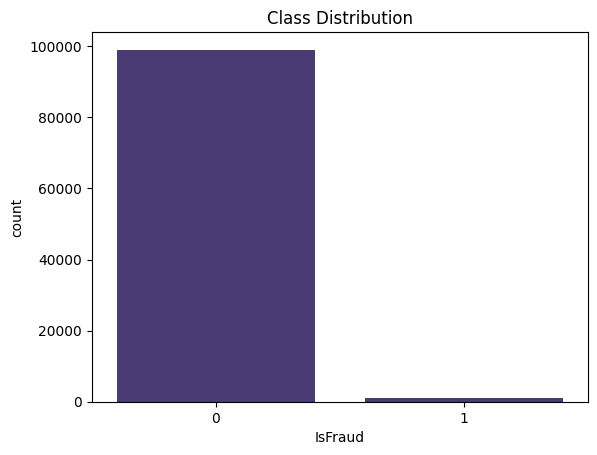

Fraud Percentage: 1.0000%


In [10]:
sns.countplot(x=df["IsFraud"])
plt.title("Class Distribution")
plt.show()

fraud_percentage = df["IsFraud"].mean() * 100
print(f"Fraud Percentage: {fraud_percentage:.4f}%")


2.2 Descriptive Statistics and Distributions

Descriptive statistics:


,Amount,MerchantID,TransactionType,Location,IsFraud,Hour,Day,Month
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,2497.092666,501.676070,0.501310,4.485300,0.010000,11.50084,15.782220,6.516240
std,1442.415999,288.715868,0.500001,2.876283,0.099499,6.91768,8.813795,3.448248
min,1.050000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
25%,1247.955000,252.000000,0.000000,2.000000,0.000000,6.00000,8.000000,4.000000
50%,2496.500000,503.000000,1.000000,4.000000,0.000000,12.00000,16.000000,7.000000
75%,3743.592500,753.000000,1.000000,7.000000,0.000000,17.00000,23.000000,10.000000
max,4999.770000,1000.000000,1.000000,9.000000,1.000000,23.00000,31.000000,12.000000


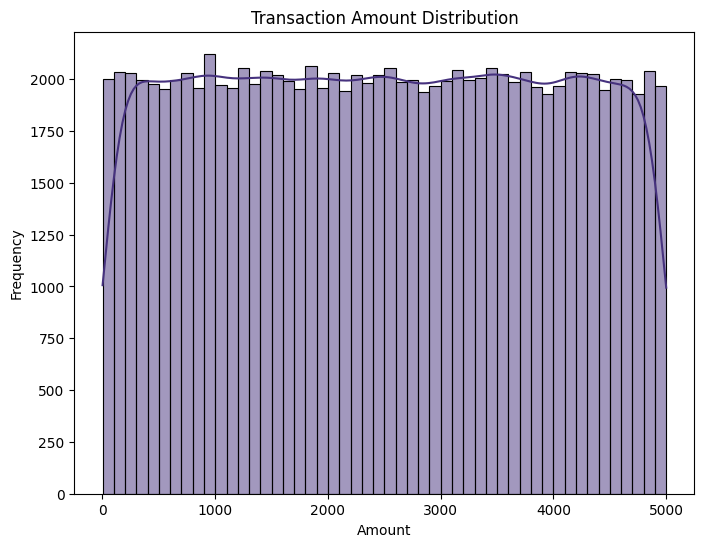

In [11]:
# Descriptive statistics of the dataset
print("Descriptive statistics:")
display(df.describe())

# Visualizing the distribution of transaction amounts
plt.figure(figsize=(8, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

2.3 Correlation Analysis

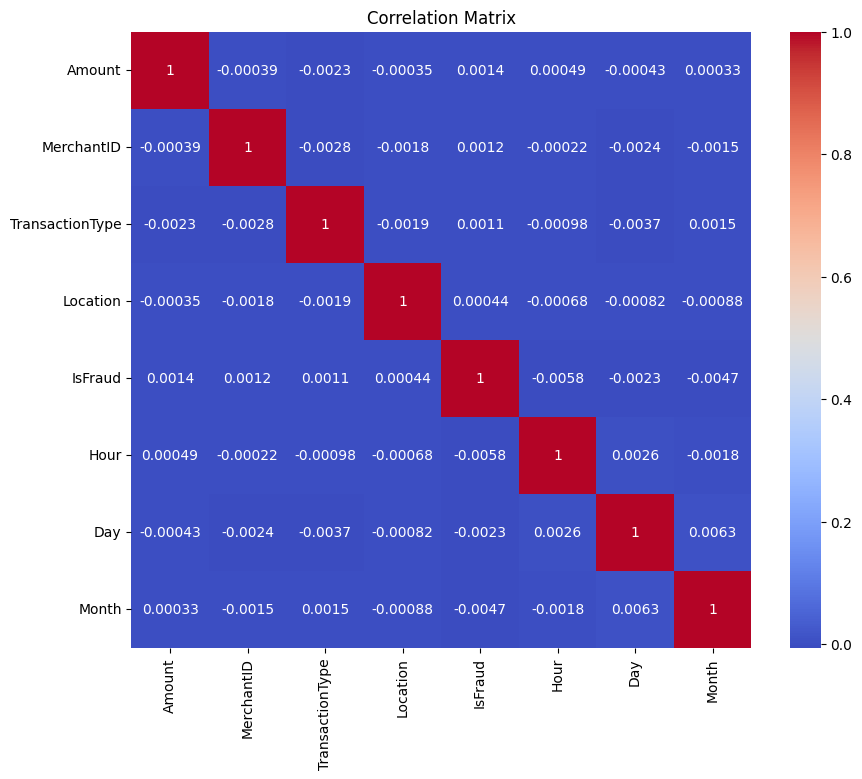

In [12]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


2.4 Fraud Distribution and Categorical Analysis

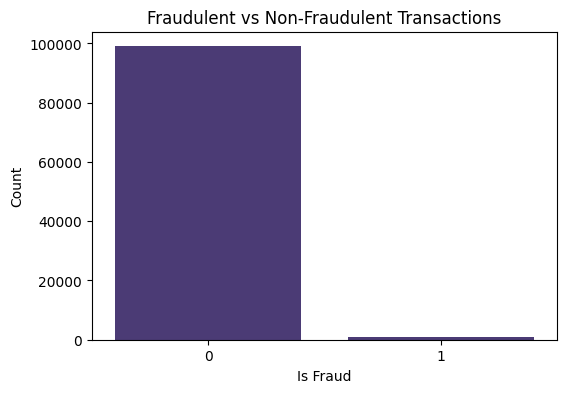

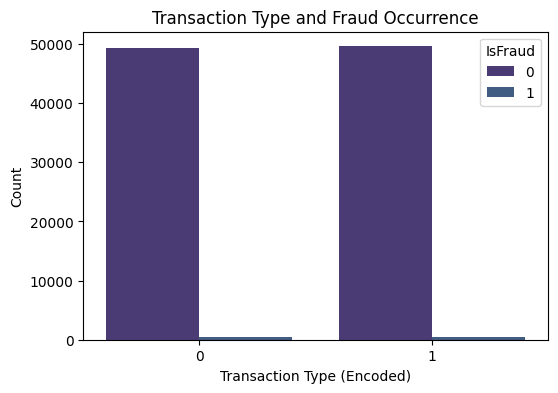

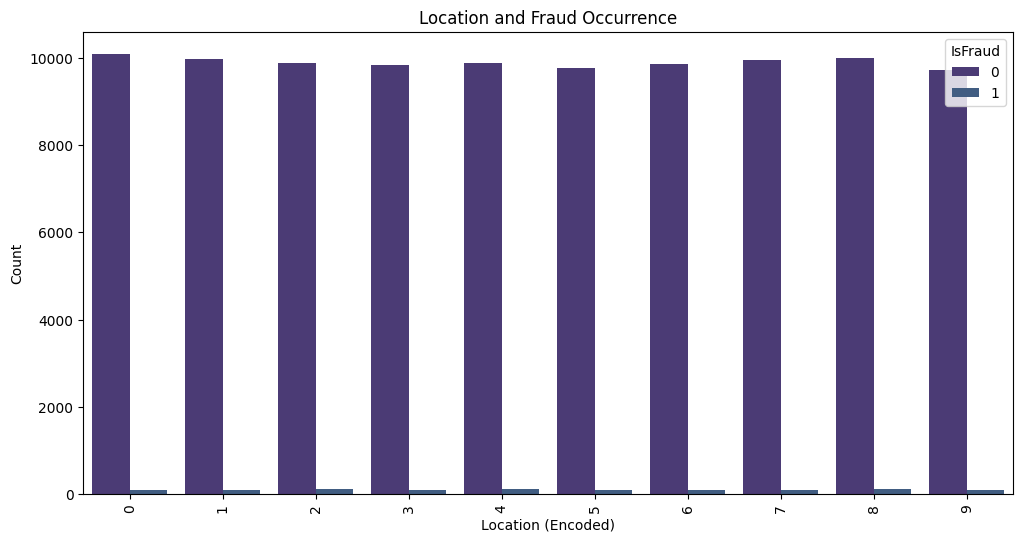

In [13]:
# Fraud distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='IsFraud', data=df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# Transaction Type vs Fraud
plt.figure(figsize=(6, 4))
sns.countplot(x='TransactionType', hue='IsFraud', data=df)
plt.title('Transaction Type and Fraud Occurrence')
plt.xlabel('Transaction Type (Encoded)')
plt.ylabel('Count')
plt.show()

# Location vs Fraud (sampled for readability if many unique values)
plt.figure(figsize=(12, 6))
sns.countplot(x='Location', hue='IsFraud', data=df)
plt.title('Location and Fraud Occurrence')
plt.xlabel('Location (Encoded)')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


#### 3. Class Imbalance Handling & Feature Scaling

In [14]:
# Separate features and target variable
X = df.drop('IsFraud', axis=1)
y = df['IsFraud']

# Address class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("After SMOTE, counts of label '1': {}".format(sum(y_res==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_res==0)))

# Scale features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)


After SMOTE, counts of label '1': 99000
After SMOTE, counts of label '0': 99000


#### 4. Model Training & Evaluation 


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61     19777
           1       0.62      0.71      0.66     19823

    accuracy                           0.64     39600
   macro avg       0.64      0.64      0.64     39600
weighted avg       0.64      0.64      0.64     39600

ROC-AUC Score: 0.6615


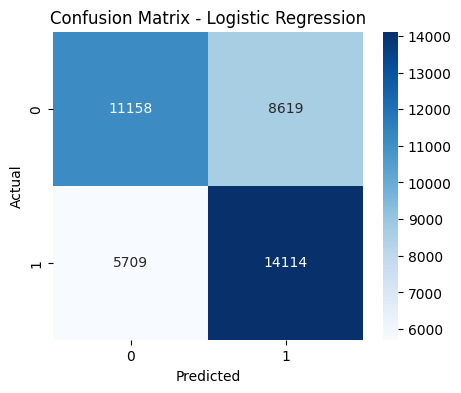

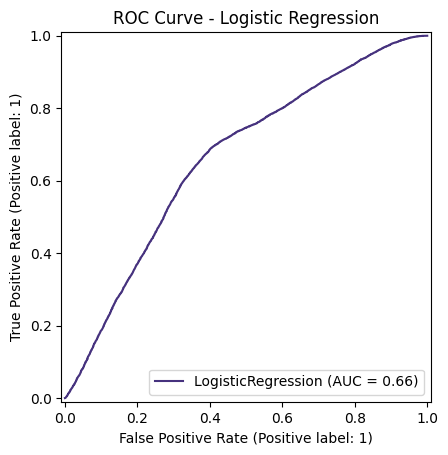


--- Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     19777
           1       0.95      0.99      0.97     19823

    accuracy                           0.97     39600
   macro avg       0.97      0.97      0.97     39600
weighted avg       0.97      0.97      0.97     39600

ROC-AUC Score: 0.9966


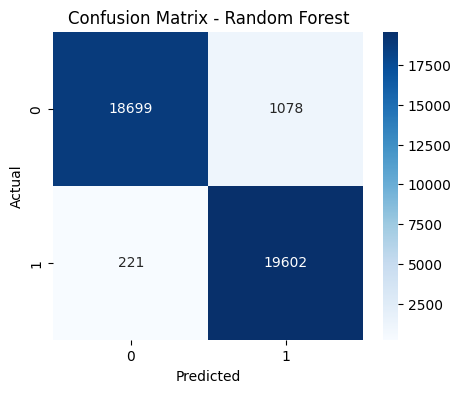

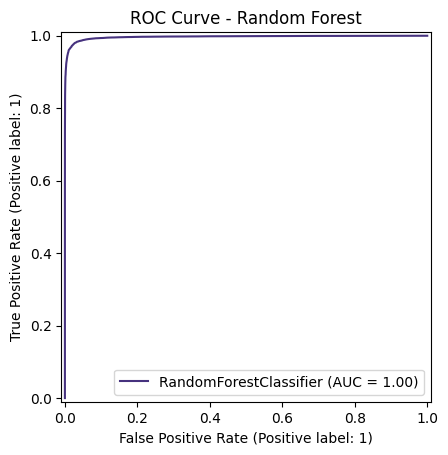


--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     19777
           1       0.84      0.95      0.89     19823

    accuracy                           0.88     39600
   macro avg       0.89      0.88      0.88     39600
weighted avg       0.89      0.88      0.88     39600

ROC-AUC Score: 0.9476


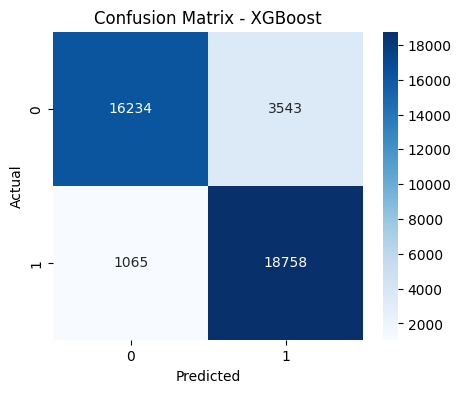

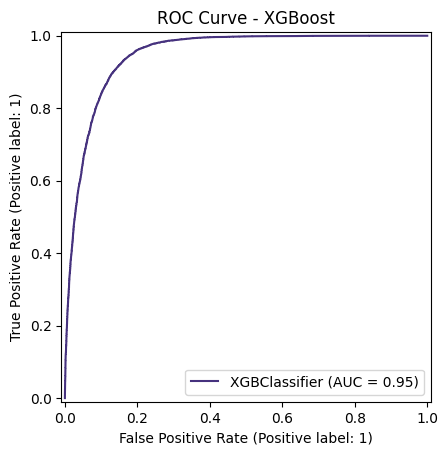

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Split the resampled and scaled data
X_train, X_test, y_train, y_test = train_test_split(X_res_scaled, y_res, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train, predict, evaluate
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC-AUC Score
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.show()


**Summary of Model Performance**

| Model | Accuracy | ROC-AUC | Notes |
|-------|----------|---------|-------|
| Logistic Regression | 64% | 0.66 | Weak linear model, underperforms on both precision and recall |
| Random Forest | 97% | 0.997 | Excellent performance; high recall and precision on both classes |
| XGBoost | 88% | 0.948 | Strong model, better balance between precision/recall |

####  5. XGBoost Tuning with RandomizedSearchCV

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}

# Set up model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Randomized Search with 3-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=30,                # number of parameter settings to sample
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters from Randomized Search:")
print(random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters from Randomized Search:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}


Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     19777
           1       0.87      0.98      0.92     19823

    accuracy                           0.92     39600
   macro avg       0.92      0.92      0.92     39600
weighted avg       0.92      0.92      0.92     39600

ROC-AUC Score (Tuned XGBoost): 0.9758519493563953


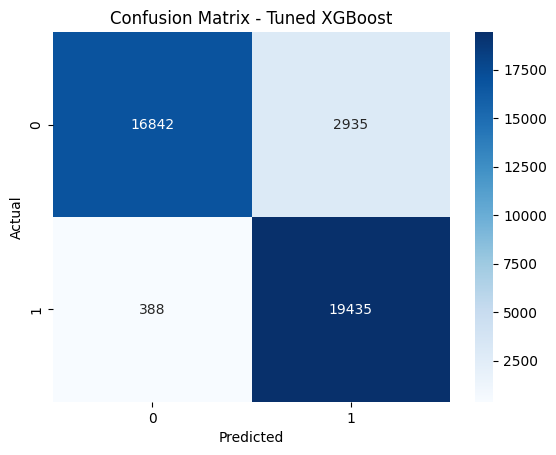

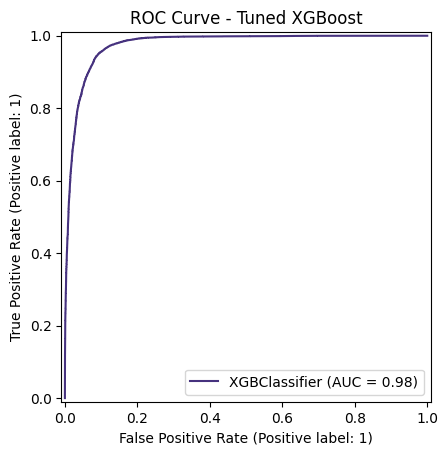

In [17]:
# Get best model and evaluate on test set
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score (Tuned XGBoost):", roc_auc_score(y_test, y_proba))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title('ROC Curve - Tuned XGBoost')
plt.show()


**Tuned XGBoost Performance Summary**
|Metric	| Before Tuning|	After Tuning|
|-------|--------------|----------------|
|Accuracy|	88%	92%    |92%|
|Precision (Fraud)|	0.84|	0.87|
|Recall (Fraud)|	0.95|	0.98|
|F1-Score (Fraud)|	0.89|	0.92|
|ROC-AUC Score|	0.9476|	0.9759|


✅ Insights:
Huge gain in recall — catching nearly all fraudulent cases now.

Better precision — fewer false alarms compared to before.

Balanced performance on both fraud and non-fraud classes

##### Model Explainability with Feature Importance

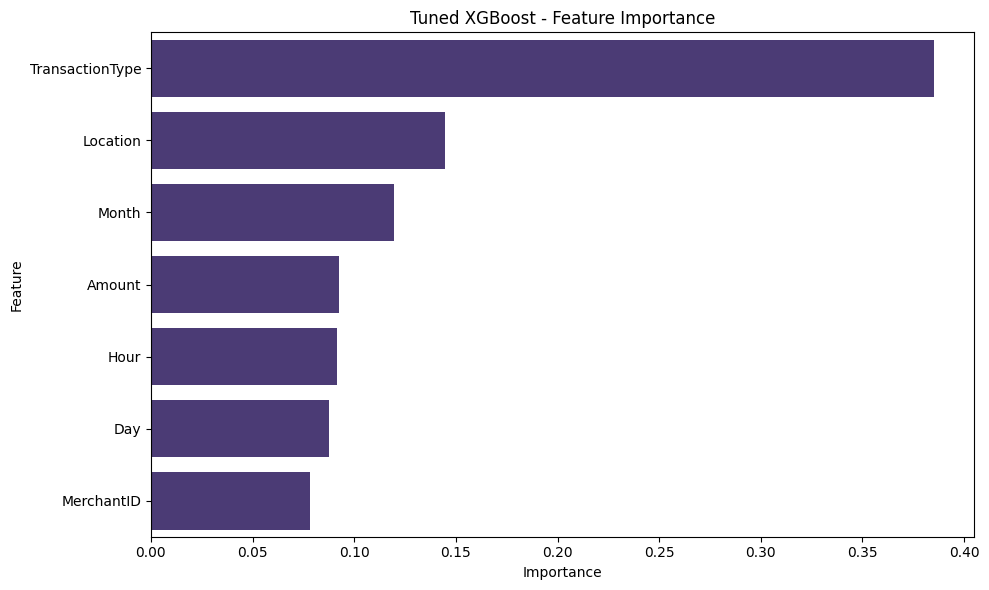

In [20]:
# Get feature importances from tuned XGBoost
xgb_importances = best_xgb.feature_importances_

# Create dataframe
xgb_feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feat_imp)
plt.title('Tuned XGBoost - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


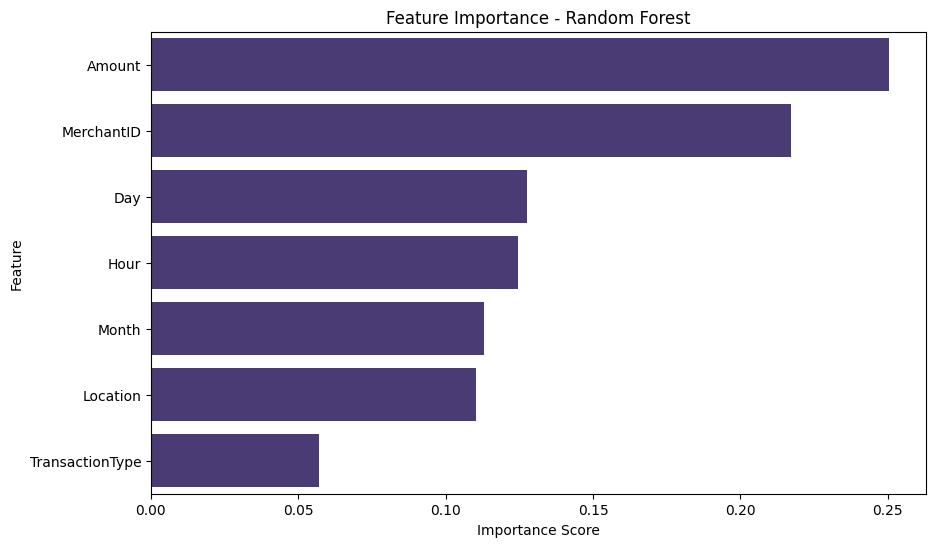

In [21]:
# Feature Importance for Random Forest
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**Insights**

- Random Forest focused heavily on Amount and MerchantID. This suggests it sees monetary patterns and specific vendors as key fraud indicators.

- Tuned XGBoost, however, placed massive weight on TransactionType — implying refund vs. purchase behavior was most predictive in that model.

- Location and Month also played a stronger role in XGBoost, possibly detecting regional and seasonal fraud patterns.

Save the Models to reuse later:

In [23]:
import joblib
# Save XGBoost model
joblib.dump(best_xgb, 'xgboost_fraud_model.pkl')

#Save Random Forest model
joblib.dump(models["Random Forest"], "random_forest_fraud_model.pkl")

['random_forest_fraud_model.pkl']